In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk import FreqDist

In [4]:
with open("data/mhbhrt/mahafull.txt", "r") as f:
    file = f.read()

In [12]:
# Get all the chapters
raw = file.split("BOOK")[1:]
len(raw)
# raw[0]

18

In [13]:
# Create the dataframe
mhb_df = pd.DataFrame({"book": raw})


In [14]:
books = mhb_df.copy()

In [15]:
books['book_title'] = books.book.str.split("\n").str[2]
books['book_num'] = books.index+1
books

,book,book_title,book_num
0,1\n\nADI PARVA\n\nTRANSLATOR'S PREFACE\n\nThe...,ADI PARVA,1
1,2\n\nSABHA PARVA\n\n\nSECTION I\n\n(Sabhakriy...,SABHA PARVA,2
2,3 \n\nVANA PARVA\n\nSECTION I\n\n(Aranyaka Pa...,VANA PARVA,3
3,4\n\nVIRATA PARVA\n\nSECTION I\n\n(Pandava-Pr...,VIRATA PARVA,4
4,5\n\nUDYOGA PARVA\n\nSECTION I\n\nOM! HAVING ...,UDYOGA PARVA,5
5,6\n\nBHISHMA PARVA\n\nSECTION I\n\n(Jamvu-kha...,BHISHMA PARVA,6
6,7\n\nDRONA PARVA\n\nSECTION I\n\n(Dronabhishe...,DRONA PARVA,7
7,8\n\nKARNA-PARVA\n\nSECTION 1\n\nOm! Having b...,KARNA-PARVA,8
8,9\n\nSHALYA-PARVA\n\nSECTION 1\n\nOm! Having ...,SHALYA-PARVA,9
9,10\n\nSAUPTIKA-PARVA\n\nSECTION 1\n\nOm! Havi...,SAUPTIKA-PARVA,10


In [16]:
# book titles and book_setions
book_sections=["book_title" + "\t" + "section_title" + "\t" + "section_content"]
for j in range(len(raw)):
    book_title = raw[j].split("\n")[2]
    book_section = raw[j].split("SECTION")[1:]
    for i in range(len(book_section)):
        loop_var = book_title + '/t' + str(book_section[i].split("\n")[0].strip()) +'\t'+ str(book_section[i][1:])
        book_sections.append(loop_var)

In [17]:
def unnest_tokens(dataframe, column, tokenizer, new_column='word'): 
    """
    Applies a tokenizer to a column and then unnest the dataframe
    
    dataframe: dataframe with text
    column: name of the column with the text
    new_column: what you want the column of words to be called
    tokenizer: a function to be used to tokenize the text
    """ 
    new_column_num = new_column + "_num"
    df = ( dataframe[column]
              .apply(tokenizer)
              .apply(pd.Series)
              .stack()
              .reset_index(level=1)
              .rename(columns={0: new_column, "level_1":new_column_num})
              .join(dataframe.drop(column, axis=1), how='left')
              .reset_index(drop=True)
         )
    df[new_column_num] = pd.to_numeric(df[new_column_num])
    df[new_column_num] = df[new_column_num] + 1
    return df

In [18]:
def section_tokenizer(text):
    return text.split("SECTION")[1:]

In [19]:
#splitting into sections using the unnest function
sections = unnest_tokens(books, "book", section_tokenizer, "section")
sections.head()

,section_num,section,book_title,book_num
0,1,I\n\nOm! Having bowed down to Narayana and Na...,ADI PARVA,1
1,2,"II\n\n""The Rishis said, 'O son of Suta, we wi...",ADI PARVA,1
2,3,"III\n\n(Paushya Parva)\n\nSauti said, ""Janame...",ADI PARVA,1
3,4,"IV\n\n(Pauloma Parva)\n\n'UGRASRAVA SAUTI, th...",ADI PARVA,1
4,5,"V\n\n(Pauloma Parva continued)\n\n""Saunaka sa...",ADI PARVA,1


In [20]:
sections['section'] = sections.section.str.replace("\n", " ")

In [21]:
import spacy
nlp = spacy.load('en')
type(nlp)

spacy.lang.en.English

In [22]:
def sentence_tokenizer(text):
    doc = nlp(text)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [23]:
sentences = unnest_tokens(sections, "section", sentence_tokenizer, "sentence")

In [24]:
def word_tokenizer(text):
    doc = nlp(text)
    words = [[token.text, token.lemma_, token.pos_, token.is_stop] for token in doc]
    return words

In [25]:
words = unnest_tokens(sentences, "sentence", word_tokenizer, "word")

In [26]:
words[['word', 'lemma', 'POS', "stop"]] = pd.DataFrame(words.word.values.tolist())

Enter the characterKrishna


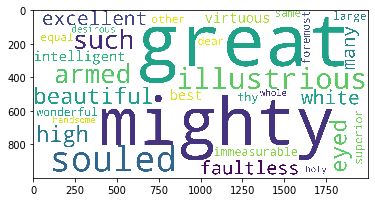

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

character = input("Enter the character")
char_mention = pd.Series(words.loc[words['word'] == character].index)
words.loc[2]['POS'] == 'ADJ'

char_temp = pd.DataFrame()
for t in range(len(char_mention)):
    i = char_mention[t] - 5
    j = char_mention[t] - 5
    while True:
        if((words.loc[j]['POS'] == 'ADJ') & (words.loc[j]['lemma'] != '-PRON-')):
            hrk = words.loc[j]
            char_temp = char_temp.append(hrk)
            j=j+1
        else:
            j=j+1
        if(j > i+10):
            break
adj_char = pd.Series(char_temp['word'])
adj_char
fdistk=FreqDist(adj_char)
myList = fdistk.most_common(30)

myDict = {}
for i in range(len(myList)):
    key = myList[i][0]
    myDict[key] = myList[i][1]
    
wc = WordCloud(background_color="white",width=2000,height=1000, max_words=30,relative_scaling=0.25,normalize_plurals=False).generate_from_frequencies(myDict)
plt.imshow(wc)